In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.models import Model
from random import randint 

from keras import backend as K 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D 
from keras.callbacks import TensorBoard 
from tensorflow.keras import layers, losses

def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

def map_func(sample):
    image = sample['image']
    label = sample['label']
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

import tensorflow_datasets as tfds

# Corrected file path with escaped backslashes and a missing comma
ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:10%]', 'test[:2.5%]', 'validation[:2.5%]'],
                         data_dir=r'C:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\Anvendtmaskinlæring\eksamen',
                         download=False,
                         shuffle_files=True)

train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

train_dataset_cnn       = ds1.map(map_func).batch(32)
validation_dataset_cnn  = ds3.map(map_func).batch(32)
test_dataset_cnn        = ds2.map(map_func).batch(32)

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Dropout, Conv2DTranspose 

In [2]:
input_shape = (96, 96, 3)
latent_dimensions = 128
dropout_rate = 0.2

def build_autoencoder(input_shape, latent_dimensions, dropout_rate):
    # Define the input layer

    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded_layer = MaxPooling2D((2, 2), padding='same')(x)
    # Latent space
    x = Flatten()(encoded_layer)
    x = Dropout(dropout_rate)(x)  # Adding Dropout regularization
    latent_layer = Dense(latent_dimensions, activation='relu')(x)

    # Create encoder model
    encoder = Model(inputs=input_layer, outputs=latent_layer)

    # Decoder
    x = Dense(encoded_layer.shape[1] * encoded_layer.shape[2] * encoded_layer.shape[3], activation='relu')(latent_layer)
    x = Reshape((encoded_layer.shape[1], encoded_layer.shape[2], encoded_layer.shape[3]))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    decoded_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Create autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded_layer)

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(input_shape, latent_dimensions, dropout_rate)
autoencoder.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Modify patience value as needed

# Train the autoencoder
autoencoder.fit(
    train_dataset,
    epochs=1,
    batch_size=128,
    shuffle=True,
    validation_data=validation_dataset,
    callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), early_stopping]
)

for layer in encoder.layers:
    layer.trainable = False


820/820 [==============================] - 190s 229ms/step - loss: 0.0372 - val_loss: 0.0363


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

def build_cnn_classifier(encoder):
    # Take the encoder's output as the starting point
    encoded_output = encoder.output
    
    # Expand the model with additional convolutional layers
    x = Reshape((-1, 1, latent_dimensions))(encoded_output)  # Reshape for convolutional layers
    x = Conv2D(128, (3, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 1), padding='same')(x)
    x = Conv2D(256, (3, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 1), padding='same')(x)
    x = Flatten()(x)  # Flatten the output to feed into dense layers

    # Additional dense layers for more complex feature learning
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Final layer for binary classification
    output_layer = Dense(2, activation='softmax')(x)
    
    # Create the CNN model using the encoder's input and the new output layer
    cnn_classifier = Model(inputs=encoder.input, outputs=output_layer)
    
    return cnn_classifier

# Adjust the latent dimensions if necessary
latent_dimensions = 128  # Ensure this matches the encoder's latent space dimension

# Build the enhanced CNN classifier
cnn_classifier = build_cnn_classifier(encoder)

# Proceed with compiling and training the model as before
cnn_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_classifier.summary()

# Note: Ensure the rest of your training code remains the same



Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 9216)              0   

In [14]:

history = cnn_classifier.fit(
    train_dataset_cnn,  # Your training dataset
    epochs=5,          # Adjust the number of epochs as needed
    validation_data=validation_dataset_cnn  # Your validation dataset
)



Epoch 1/5
820/820 [==============================] - 18s 20ms/step - loss: 2.8325 - accuracy: 0.6411 - val_loss: 0.6195 - val_accuracy: 0.7033
Epoch 2/5
820/820 [==============================] - 16s 20ms/step - loss: 0.6206 - accuracy: 0.6839 - val_loss: 0.5681 - val_accuracy: 0.7045
Epoch 3/5
820/820 [==============================] - 16s 20ms/step - loss: 0.5883 - accuracy: 0.6942 - val_loss: 0.5397 - val_accuracy: 0.7228
Epoch 4/5
628/820 [=====================>........] - ETA: 3s - loss: 0.5742 - accuracy: 0.7046

KeyboardInterrupt: 

In [11]:
test_loss, test_accuracy = cnn_classifier.evaluate(test_dataset_cnn)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")


26/26 [==============================] - 0s 12ms/step - loss: 0.7703 - accuracy: 0.5006
Test accuracy: 0.5006105303764343, Test loss: 0.770312488079071


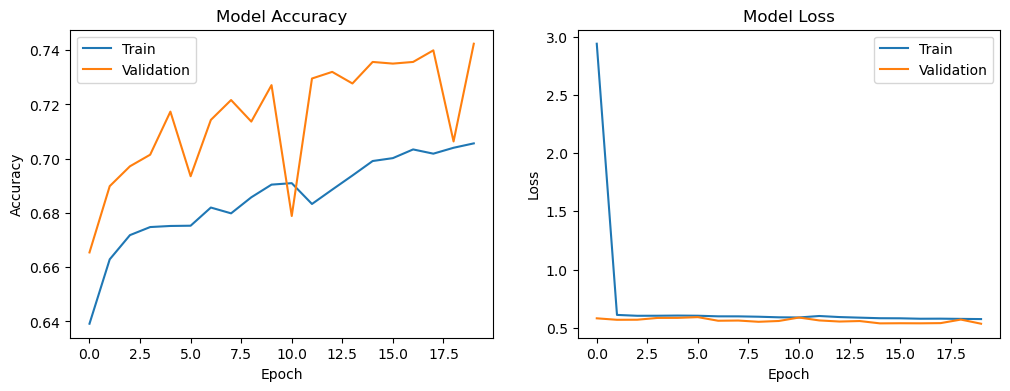

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()